# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


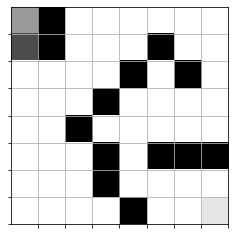

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = [] # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    loss = 0
    n_episodes = 0
    
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
    
    for epoch in range(n_epoch): 
        #randomly selct free cell
        agent_cell = random.choice(qmaze.free_cells)
        #reset maze
        qmaze.reset(agent_cell)
        #current environment state
        envstate = qmaze.observe()
        gameOver = False
        
        while not gameOver:
            previous_envstate = envstate
            #exploration
            r = np.random.rand()
            if r <= epsilon:
                action = random.choice(qmaze.valid_actions())
            #exploitation
            else:
                q = experience.predict(previous_envstate)
                action = np.argmax(q)
            
            #return envstate, reward, game_status based on the action
            envstate, reward, game_status = qmaze.act(action)
            
            print(game_status)
            if game_status=='win':
                gameOver = True
                #add win to win history array
                win_history.append(1)
                
                
            if game_status == 'lose':
                gameOver = True
                #add loss to win_history array
                win_history.append(0)
            
            #store episode, increment number of episodes
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            n_episodes+=1
            
            #get training data
            inputs, targets = experience.get_data(data_size = data_size) 
            
            #evaluate model
            m = model.fit(inputs, targets, batch_size = 20, epochs = 8 )
            loss = model.evaluate(inputs, targets)
            
            
            

        
        

    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

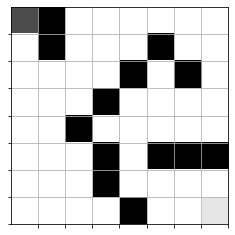

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

not_over
Epoch 1/8
1/1 [==============================] - 1s 504ms/step - loss: 0.3330
Epoch 2/8
1/1 [==============================] - 0s 1ms/step - loss: 0.1985
Epoch 3/8
1/1 [==============================] - 0s 2ms/step - loss: 0.1115
Epoch 4/8
1/1 [==============================] - 0s 2ms/step - loss: 0.0621
Epoch 5/8
1/1 [==============================] - 0s 3ms/step - loss: 0.0370
Epoch 6/8
1/1 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 7/8
1/1 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 8/8
1/1 [==============================] - 0s 70ms/step
not_over
Epoch 1/8
2/2 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 2/8
2/2 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 3/8
2/2 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 4/8
2/2 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 5/8
2/2 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 

Epoch 8/8
12/12 [==============================] - 0s 83us/step
not_over
Epoch 1/8
13/13 [==============================] - 0s 231us/step - loss: 7.0171e-04
Epoch 2/8
13/13 [==============================] - 0s 233us/step - loss: 7.0019e-04
Epoch 3/8
13/13 [==============================] - 0s 154us/step - loss: 6.9612e-04
Epoch 4/8
13/13 [==============================] - 0s 152us/step - loss: 6.9638e-04
Epoch 5/8
13/13 [==============================] - 0s 155us/step - loss: 6.9902e-04
Epoch 6/8
13/13 [==============================] - 0s 118us/step - loss: 6.9825e-04
Epoch 7/8
13/13 [==============================] - 0s 230us/step - loss: 6.9570e-04
Epoch 8/8
13/13 [==============================] - 0s 76us/step
not_over
Epoch 1/8
14/14 [==============================] - 0s 359us/step - loss: 6.9075e-04
Epoch 2/8
14/14 [==============================] - 0s 288us/step - loss: 6.8646e-04
Epoch 3/8
14/14 [==============================] - 0s 146us/step - loss: 6.8238e-04
Epoch 4/8
14/1

not_over
Epoch 1/8
24/24 [==============================] - 0s 250us/step - loss: 4.3171e-04
Epoch 2/8
24/24 [==============================] - 0s 208us/step - loss: 4.4661e-04
Epoch 3/8
24/24 [==============================] - 0s 208us/step - loss: 4.2910e-04
Epoch 4/8
24/24 [==============================] - 0s 167us/step - loss: 4.5809e-04
Epoch 5/8
24/24 [==============================] - 0s 251us/step - loss: 4.6189e-04
Epoch 6/8
24/24 [==============================] - 0s 251us/step - loss: 4.7699e-04
Epoch 7/8
24/24 [==============================] - 0s 251us/step - loss: 4.7460e-04
Epoch 8/8
24/24 [==============================] - 0s 84us/step
not_over
Epoch 1/8
25/25 [==============================] - 0s 240us/step - loss: 3.9879e-04
Epoch 2/8
25/25 [==============================] - 0s 240us/step - loss: 4.6847e-04
Epoch 3/8
25/25 [==============================] - 0s 239us/step - loss: 4.2837e-04
Epoch 4/8
25/25 [==============================] - 0s 161us/step - loss: 4.507

32/32 [==============================] - 0s 157us/step - loss: 3.3571e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 3.2727e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 3.2656e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 3.3464e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.3510e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 3.3720e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 193us/step - loss: 3.3875e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 3.3422e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 3.3063e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 3.3165e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.2816e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 188us/step - loss: 9.8442e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.6279e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 9.4945e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.7912e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.8418e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0050
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0050
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0051
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0050
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0052
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0054
Epoch 7/8
32/32 [====================

32/32 [==============================] - 0s 158us/step - loss: 0.0042
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0034
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 0.0034
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0035
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0035
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0034
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0033
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 0.0033
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0035
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0039
Epoch 3/8
32/32 [==============================] - 0s 156us/step

32/32 [==============================] - 0s 125us/step - loss: 0.0108
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0106
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0104
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0108
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0105
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0106
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0052
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0049
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0050
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 0.0051
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0047
Epoch 6/8
32/32 [==============================] - 0s 157

32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0026
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0025
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0024
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 0.0025
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0024
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0024
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0024
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 187us/step

32/32 [==============================] - 0s 375us/step - loss: 0.0048
Epoch 4/8
32/32 [==============================] - 0s 344us/step - loss: 0.0064
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0055
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0043
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0067
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0046
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0049
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0047
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0050
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0043
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0046
Epoch 7/8
32/32 [==============================] - 0s 126

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0025
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0041
Epoch 3/8
32/32 [==============================] - 0s 155us/step - loss: 0.0028
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0026
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0022
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0024
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0032
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0027
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0028
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0025
Epoch 4/8
32/32 [==============================] - 0s 188us/step

32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.5430e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 7/8
32/32 [==============================] - 0s

32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 7.1107e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.9579e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.5494e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.2224e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 6.2490e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 6.4552e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 6.2886e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [===================

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 9.9208e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/

32/32 [==============================] - 0s 189us/step - loss: 6.2665e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.2801e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.2776e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.1413e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 6.1170e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 126us/step - loss: 9.3543e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 9.9385e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.9052e-04
Epoch 7/8
32/32 [========

32/32 [==============================] - 0s 188us/step - loss: 4.5552e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 4.3009e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 3.9473e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 3.8611e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.4814e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.4695e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 9.7868e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 8.3213e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.8759e-04
Epoch 6/8
32/32 [==============================] - 0s 155us/step - loss: 9.6228e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.8631e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 313us/step - loss: 7.8635e-04
Epoch 6/8
32/32 [==============================] - 0s 251us/step - loss: 8.7135e-04
Epoch 7/8
32/32 [==============================] - 0s 282us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 94us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 7.6995e-04
Epoch 2/8
32/32 [==============================] - 0s 282us/step - loss: 7.4039e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 8.3199e-04
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 8.2195e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 7.2060e-04
Epoch 6/8
32/32 [==============================] - 0s 251us/step - loss: 6.9915e-04
Epoch 7/8
32/32 [==============================] - 0s 281us/step - loss: 5.9373e-04
Epoch 8/8
32/32 [==============================] - 0s 125us/step
not_over
Epoch 1/8
32/32 [==========

32/32 [==============================] - 0s 157us/step - loss: 6.9589e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.6519e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.3743e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 3.8765e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 4.2572e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.1809e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 4.0245e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.0024e-04
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 3.8852e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 1.3235e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 6.5718e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 5.1202e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 4.1227e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 3.9761e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 5.5652e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.4548e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 3.2803e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 2.9849e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 3.9574e-04
Epoch 2/8
32/32 [==============================] - 0s 314us/step - loss: 3.3725e-04
Epoch 3/8
32/32 [=======

32/32 [==============================] - 0s 158us/step - loss: 1.5220e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 8.5596e-05
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.9510e-05
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 8.8965e-05
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 8.2997e-05
Epoch 5/8
32/32 [==============================] - 0s 125us/step - loss: 8.3645e-05
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 7.3413e-05
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 7.4427e-05
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 3.4874e-04
Epoch 2/8
32/32 [==============================] - 0s 218us/step - loss: 3.7790e-04
Epoch 3/8
32/32 [=======

32/32 [==============================] - 0s 95us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 1.8766e-04
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 2.0645e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 2.1466e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 1.9757e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 2.1011e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 1.9862e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 1.9498e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.0424e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.3656e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.4548e-04
Epoch 4/8
32/32 [=======

not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 2.6068e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 2.8176e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 3.9624e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.5853e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 4.2674e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 3.1108e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 3.2054e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 2.4238e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 2.5200e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 3.2677e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 2.849

32/32 [==============================] - 0s 157us/step - loss: 8.4846e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 8.9922e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.3356e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.6500e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.7990e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.5916e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 7.2514e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.7671e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 7.7400e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.4173e-04
Epoch 6/8
32/32 [

32/32 [==============================] - 0s 188us/step - loss: 9.7291e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.7975e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 8.0978e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 9.3481e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0016
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 7/8
32/32 [========================

32/32 [==============================] - 0s 188us/step - loss: 3.8852e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 3.4723e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.7635e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 4.1401e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 8.4176e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.7134e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.0564e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.0769e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 8.5411e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 7.9473e-04
Epoch 7/8
32/32 [==============================] - 0s 125us/step - loss: 7.6432e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 188us/step - loss: 7.7302e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 7.7421e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 8.0732e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.6383e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 5.0641e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 4.7539e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.6455e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.7682e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.6092e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.2587e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 7.3481e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 7.1988e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 8.7211e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 8.7005e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 8.6186e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.4633e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 8.1652e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.4162e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 9.5556e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 126us/step - loss: 9.2887e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.5472e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 4.4741e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 4.3907e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.5695e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.7348e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.2539e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.5028e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 7.4443e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.0099e-04
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 7.7333e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 220us/step - loss: 8.8726e-04
Epoch 2/8
32/32 [==============================] - 0s 127us/step - loss: 9.9475e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 5.3289e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.7330e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 4.9503e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.8502e-04
Epoch 5/8
32/32 [================

32/32 [==============================] - 0s 188us/step - loss: 2.2921e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 2.3403e-04
Epoch 4/8
32/32 [==============================] - 0s 251us/step - loss: 2.2817e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 2.1862e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 2.1516e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 1.9693e-04
Epoch 8/8
32/32 [==============================] - 0s 94us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 1.7236e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 2.2323e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 1.8318e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 1.6037e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 1.4636e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 188us/step - loss: 7.1767e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.4124e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 6.5695e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 6.7943e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 6.5916e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 468us/step - loss: 3.9680e-04
Epoch 2/8
32/32 [==============================] - 0s 344us/step - loss: 4.3937e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 5.2070e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.3300e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 4.1650e-04
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 4.1373e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 156us/step - loss: 8.0067e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 8.2026e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 8.1973e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 8.0624e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.0974e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.2812e-05
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 1.3726e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 1.2233e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.7701e-05
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 1.9306e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 8.9864e-05
Epoch 7/8
32/

32/32 [==============================] - 0s 188us/step - loss: 6.9197e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 6.6485e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.1136e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 5.8812e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 2.2978e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 2.4895e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 2.3618e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 2.1314e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 2.1139e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 2.1513e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 2.0049e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 157us/step - loss: 7.1132e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 5.6631e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 7.7339e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 6.8359e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 6.9128e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.4201e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 6.7204e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.1684e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 6.4483e-04
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 6.6411e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 1.7263e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 2.3100e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 2.0986e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 2.0689e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 2.0069e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 1.9456e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 1.7129e-04
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.4604e-04
Epoch 2/8
32/32 [================

Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.9243e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.7157e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.9442e-04
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 7.8645e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.8705e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.7083e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.7245e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 2.9312e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 3.0068e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 2.7208e-04
Epoch 4/8
32/3

32/32 [==============================] - 0s 188us/step - loss: 8.1692e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 8.1885e-04
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 8.2246e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 8.0362e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.4137e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 8.4160e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.4016e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 5.2705e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 5.3470e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 4.7989e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 5.2674e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 9.8898e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 2.8291e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 2.9897e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 3.1017e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 2.7812e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 2.9263e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 2.4912e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 2.2365e-04
Epoch 8/8
32/32 [========

32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.0212e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 9.6780e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 9.4767e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 7.3677e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.4515e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 7.6839e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======================

32/32 [==============================] - 0s 219us/step - loss: 4.6379e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.1330e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.9490e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.0307e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.3859e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 7.1274e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.8707e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.0484e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 5.2618e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 5.1490e-04
Epoch 3/8
32/32 [=======

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.5444e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.5138e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 9.2134e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 8.8284e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.8114e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 8.6415e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.9288e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 155us/step - loss: 0.0012
Epoch 4/8
32/32 [===================

32/32 [==============================] - 0s 157us/step - loss: 0.0054
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0033
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0104
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0074
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0055
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0038
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0021
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.5661e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0020
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s

32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.2184e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 3.6787e-04
Epoch 3/8
32/32 [==============================] - 0s 281us/step - loss: 3.8963e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 3.7058e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 3.7411e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 3.4303e-04
Epoch 7/8
32/32 [================

32/32 [==============================] - 0s 156us/step - loss: 9.5187e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 8.7790e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.4628e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.7489e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 8.5036e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.3301e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 7.0987e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 6.1186e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 5.7181e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 6.4447e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 5.7383e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 375us/step - loss: 5.7449e-04
Epoch 6/8
32/32 [==============================] - 0s 376us/step - loss: 5.6991e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 5.9518e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.9674e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 7.8350e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.2903e-04
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 7.7561e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 7.4866e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.4043e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.3551e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 210us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.0956e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.8173e-04
Epoch 3/8
32/32 [=============================

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 4.4527e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 5.1477e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.2810e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 4.4815e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.7857e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 5.3319e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 4.4851e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 4.8311e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.6111e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 4.4126e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 6.3437e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 6.8105e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.3464e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.0830e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 5.9383e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 6.0984e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.5502e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.1436e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.4852e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.9977e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.2902e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 127us/step - loss: 8.6715e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.0564e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.8547e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.1629e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.5568e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 7.8519e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 3.8788e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 3.4967e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 3.7738e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 3.5591e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.4522e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 188us/step - loss: 9.0782e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 9.9673e-04
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 8.9126e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.8779e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.0872e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.5611e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 6.0797e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 5.9362e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 5.8291e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.6853e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 5.0738e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 157us/step - loss: 8.7829e-04
Epoch 7/8
32/32 [==============================] - 0s 125us/step - loss: 7.1571e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.2150e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 9.0837e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 9.5433e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.6538e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.9966e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.4052e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.7950e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.5970e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 156us/step - loss: 1.4747e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.0778e-04
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 7.2942e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 6.9840e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.7058e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 7.3581e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 6.5157e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 6.4662e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 3/8
32/32 [===============

not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 2.3150e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 2.2104e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 2.2012e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 1.9025e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 2.0557e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 1.7962e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 1.8392e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.5109e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.5445e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 7.2875e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.340

32/32 [==============================] - 0s 157us/step - loss: 7.1988e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.8839e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.0532e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.9590e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.5875e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.5164e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 1.0881e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 9.2675e-05
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 9.8730e-05
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 9.6003e-05
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 9.6762e-05
Epoch 6/8
32/

32/32 [==============================] - 0s 187us/step - loss: 9.2801e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.1494e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.5498e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.3024e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 8.8694e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 6.1037e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.9424e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 5.7101e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 6.0193e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 5.6085e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 5.8320e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 188us/step - loss: 4.0743e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.7536e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 4.0801e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.8183e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 6.1607e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.3646e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 6.2620e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 6.2062e-04
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 6.4178e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 6.4374e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 190us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.3992e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.4053e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.1117e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 6.1516e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.8723e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.1610e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.0644e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.6274e-04
Epoch 2/8
32/32 [===============

not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 9.6376e-04
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 9.4023e-04
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 9.4295e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 9.4423e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.0288e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 9.1590e-04
Epoch 7/8
32/32 [==============================] - 0s 531us/step - loss: 9.2259e-04
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 7.8643e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.4075e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.6099e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.545

32/32 [==============================] - 0s 251us/step - loss: 9.7705e-04
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 9.6339e-04
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 9.2938e-04
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 8.9329e-04
Epoch 7/8
32/32 [==============================] - 0s 500us/step - loss: 8.3779e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 7/8
32/32 [====================

32/32 [==============================] - 0s 188us/step - loss: 9.5765e-04
Epoch 6/8
32/32 [==============================] - 0s 125us/step - loss: 9.7021e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.6977e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 7.7786e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.7133e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 7.9609e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.9204e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 7.7056e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.3355e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.6651e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 1.1229e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 1.0561e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 3.9076e-04
Epoch 2/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 6.1423e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 6.1784e-04
Epoch 3/8
32/32 [==============================] - 0s 155us/step - loss: 5.9470e-04
Epoch 4/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 156us/step - loss: 8.7711e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 8.9718e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.8380e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 8.5744e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 8.6668e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.3130e-04
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 8.1717e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.5417e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 6.9990e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 6.5078e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 6.5320e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 188us/step - loss: 8.2341e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 7.4118e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.1860e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.4055e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.9465e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 7.8203e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 4.8573e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 4.4989e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.1083e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 4.5676e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 5.0180e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 187us/step - loss: 7.8046e-04
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 7.5313e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 7.4347e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.5024e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.3389e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 7/8
32/32 [====================

32/32 [==============================] - 0s 126us/step - loss: 8.0738e-05
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 7.7295e-05
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.2520e-05
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.7033e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.7288e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 8.3698e-04
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 8.6651e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 8.5636e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 8.6493e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.3063e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 4.6278e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 4.5145e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 174us/step - loss: 2.4709e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 2.7078e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 2.5366e-04
Epoch 4/8
32/32 [==============================] - 0s 155us/step - loss: 2.3380e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 2.5914e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 2.2740e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 2.4288e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 9.4370e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 188us/step - loss: 6.0281e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 5.1168e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.0529e-04
Epoch 3/8
32/32 [==============================] - 0

Epoch: 005/14999 | Loss: 0.0005 | Episodes: 751 | Win count: 1 | Win rate: 0.000 | time: 76.3 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 8.3644e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.0531e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.9298e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.0502e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 7.0865e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 7.4567e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.4851e-04
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 9.8665e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 9.3609e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/s

32/32 [==============================] - 0s 156us/step - loss: 6.9113e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.7433e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.8536e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.1344e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 7.9009e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.6089e-04
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 7.6653e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 2.8505e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 2.8235e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 2.9157e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 2.7090e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 157us/step - loss: 0.0026
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0030
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0028
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0025
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0025
Epoch 7/8
32/32 [==============================] - 0s 155us/step - loss: 0.0023
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 487us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 312us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 282us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 189

32/32 [==============================] - 0s 188us/step - loss: 9.3303e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.0391e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 8.9333e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 5.0087e-04
Epoch 2/8
32/32 [==============================] - 0s 438us/step - loss: 5.0321e-04
Epoch 3/8
32/32 [==============================] - 0s 407us/step - loss: 5.0731e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 4.9506e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 4.8630e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 5.0135e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.8738e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 156us/step - loss: 6.4689e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 155us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 125us/

32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0074
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0075
Epoch 3/8
32/32 [==============================] - 0s 125us/step - loss: 0.0069
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0073
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0064
Epoch 6/8
32/32 [==============================] - 0s 126

32/32 [==============================] - 0s 188us/step - loss: 7.2448e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.3202e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 6.7476e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 219us/step - loss: 3.6459e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.7412e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 5.7624e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.7188e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 5.5301e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 5.9819e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 6.2536e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 5.9673e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [===============

32/32 [==============================] - 0s 157us/step - loss: 6.7687e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.5785e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.7495e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.6066e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.8652e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.4299e-04
Epoch 7/8
32/32 [==============================] - 0s 249us/step - loss: 6.5063e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.5126e-04
Epoch 2/8
32/32 [==============================] - 0s 155us/step - loss: 6.5666e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.4673e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 6.4204e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 125us/step - loss: 0.0126
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0125
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0121
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0125
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0125
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0123
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0077
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0079
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0074
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0070
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0074
Epoch 6/8
32/32 [==============================] - 0s 188

32/32 [==============================] - 0s 156us/step - loss: 5.3336e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.7078e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.6120e-04
Epoch 7/8
32/32 [==============================] - 0s 218us/step - loss: 5.1121e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 6.3752e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 5.4511e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.5599e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 5.9543e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 5.6198e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 5.7458e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 5.4334e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 156us/step - loss: 9.5615e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 9.7474e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 3.6838e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 3.6480e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 3.3128e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 3.5215e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 3.3442e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 3.5142e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 3.4569e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 2/8
32/32 [===========

Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.2871e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.5979e-04
Epoch 3/8
32/32 [==============================] - 0s 155us/step - loss: 6.5859e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.0150e-04
Epoch 5/8
32/32 [==============

32/32 [==============================] - 0s 188us/step - loss: 4.0043e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 3.8025e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.9360e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 3.6109e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0031
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0031
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0029
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0030
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0030
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0032
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0028
Epoch 8/8
32/32 [========================

32/32 [==============================] - 0s 126us/step - loss: 7.6005e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 3/8
32/32 [==============================] - 0s 157us/

Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0019
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0017
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0017
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0023
Epoch 2/8
32/32 [==============================] - 0s 469us/step - loss: 0.0021
Epoch 3/8
32/32 [==============================] - 0s 313us/step - loss: 0.0021
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0019
Epoch 5/8
32/32 [==============================

32/32 [==============================] - 0s 186us/step - loss: 4.7660e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.6632e-04
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 4.7917e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.6330e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 251us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 249us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 719us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 281us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [========================

32/32 [==============================] - 0s 189us/step - loss: 6.5436e-04
Epoch 8/8
32/32 [==============================] - 0s 30us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.6411e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 9.6238e-04
Epoch 3/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 156us/step - loss: 7.2489e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.1464e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 6.8126e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 6.6363e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.3012e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.6473e-04
Epoch 7/8
32/32 [==============================] - 0s 125us/step - loss: 5.8197e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.4526e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 5.7651e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.1775e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 6.9389e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 188us/step - loss: 0.0021
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 0.0019
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 7/8
32/32 [==============================] - 0s 125us/step - loss: 0.0017
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 188

32/32 [==============================] - 0s 188us/step - loss: 8.4940e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0098
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0092
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0096
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0102
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 0.0092
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0090
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0088
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0079
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 0.0076
Epoch 3/8
32/32 [==============================] - 0s 157us/

32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 250us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 126us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 188

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.1743e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.2537e-04
Epoch 3/8
32/32 [==============================] - 0s 282us/step - loss: 8.2340e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 7.6810e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 7.4162e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.0340e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.7506e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 9.3324e-04
Epoch 2/8
32/32 [==============================] - 0s 155us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.4516e-04
Epoch 4/8
32/32 [===========

Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 3.3386e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.5566e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 3.6352e-04
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 3.1177e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 2.6637e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 3.3270e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.7489e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.5109e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 9.6418e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.3416e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.5735e-04
Epo

32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 281us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 63u

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.2740e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 9.7642e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.4396e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.5357e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.3357e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 9.4228e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.8240e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 7.9107e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 8.1919e-04
Epoch 4/8
32/32 [===========

32/32 [==============================] - 0s 157us/step - loss: 7.1096e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.2988e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 8.8440e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 7.3935e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 7.3852e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.5137e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 5/8
32/32 [================

32/32 [==============================] - 0s 187us/step - loss: 7.2964e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.1302e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 7.1162e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.0730e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.2173e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 5.9343e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 6.0656e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 5.9747e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.0936e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 6.1013e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 5.8159e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 188us/step - loss: 8.7957e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 8.3690e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.5915e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 282us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 251us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 189us/step - loss: 6.9437e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 8.9473e-04
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 8.6485e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 9.3458e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.9544e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.1174e-04
Epoch 6/8
32/32 [==============================] - 0s 468us/step - loss: 8.5821e-04
Epoch 7/8
32/32 [==============================] - 0s 376us/step - loss: 9.9665e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 3/8
32/32 [===============

not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0054
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0046
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0043
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 0.0038
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0038
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0045
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0037
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 218us/step - loss: 0.0022
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0019
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0022
Epoch 5/8
32/32 [=====================

32/32 [==============================] - 0s 188us/step - loss: 5.9268e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 5.0648e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 4.0585e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 3.9423e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.3063e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0016
Epoch 7/8
32/32 [====================

32/32 [==============================] - 0s 157us/step - loss: 0.0019
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.2365e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.4761e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.3932e-04
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 7.7525e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 6.7018e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 7.5937e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.9326e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 2/8
32/32 [===================

not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.8137e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.8126e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 0.0012
Epoch 5/8
32/32 [=============

32/32 [==============================] - 0s 157us/step - loss: 0.0046
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0028
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0031
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0036
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.0423e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 7.6203e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.2245e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 8.7173e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 4.7909e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 5.2692e-04
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 5.3450e-04
Epoch 8/8
32/32 [============

32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 3.8685e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.3135e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 4.0210e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 3.8237e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 3.6488e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 3.7939e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 3.5359e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 125us/step - loss: 5.7822e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 5.6660e-04
Epoch 3/8
32/32 [============

32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.1194e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.1141e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.7840e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0019
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0019
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0018
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 6/8
32/32 [============================

32/32 [==============================] - 0s 157us/step - loss: 6.9271e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 7.6796e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.2186e-04
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 4.5656e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.2782e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 4.1408e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 4.2033e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 3.9902e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.1158e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.7312e-04
Epoch 2/8
32/32 [=======

not_over
Epoch 1/8
32/32 [==============================] - 0s 251us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 9.3054e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.9871e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 6.6471e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.9022e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.4694e-04
Epoch 5/8
32/32 [=

Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 7.6659e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 7.3045e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 7.0202e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.6903e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.9492e-04
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 7.3289e-04
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 7.8931e-04
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 8.1212e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 8.0208e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 7.4471e-04
Epoch 7/8
32/32 [==============================] - 0s 500us/step - loss: 7.8097e-04
Epo

32/32 [==============================] - 0s 157us/step - loss: 4.9947e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.1463e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 4.5443e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 312us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 9.7720e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================]

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.4258e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.2875e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.3519e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 5.1522e-04
Epoch 4/8
32/32 [==============================]

Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.0787e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.4054e-04
Epoch 5/8
32/32 [==============================] - 0s 250us/step - loss: 9.1048e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.6753e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.9755e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 8.3061e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 9.6371e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 9.4253e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.6762e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 9.3144e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.3991e-04
Epo

32/32 [==============================] - 0s 157us/step - loss: 6.5058e-04
Epoch 5/8
32/32 [==============================] - 0s 218us/step - loss: 6.6744e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.1809e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 6.9871e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 8/8
32/32 [========================

32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 9.9513e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.6892e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 8.4698e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.8321e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.9891e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 8.7000e-04
Epoch 2/8
32/32 [=======================

32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0019
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0019
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0019
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 0.0019
Epoch 5/8
32/32 [==============================] - 0s 156

32/32 [==============================] - 0s 156us/step - loss: 8.8529e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.6051e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.8709e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 7.6920e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 8.5268e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.0662e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 8.4497e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 8.1640e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 7.7438e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.7535e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.3179e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.1831e-04
Epoch 3/8
32/32 [==============================] - 0s 125us/step - loss: 8.9005e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 8.3785e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 8.1424e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.4626e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.2854e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 4/8
32/32 [===================

32/32 [==============================] - 0s 188us/step - loss: 5.1933e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 4.9108e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 5.2318e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 4.6790e-04
Epoch 7/8
32/32 [==============================] - 0s 125us/step - loss: 4.8994e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 9.6040e-04
Epoch 7/8
32/32 [================

32/32 [==============================] - 0s 157us/step - loss: 7.3585e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 7.0319e-04
Epoch 8/8
32/32 [==============================] - 0s 30us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 218us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 18

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.4017e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.3703e-04
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 8.6185e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 8.5199e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 8.3324e-04
Epoch 6/8
32/32 [==============================] - 0s 186us/step - loss: 8.2890e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 8.5356e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 438us/step - loss: 0.0011
Epoch 4/8
32/32 [===================

32/32 [==============================] - 0s 157us/step - loss: 7.0352e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 6.8898e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 7.1886e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.1302e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 7.0824e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 6.9633e-04
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 7.0927e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.6380e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.2236e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 9.1927e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.9042e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 251us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 501us/step - loss: 0.0017
Epoch 5/8
32/32 [==============================] - 0s 313us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 5.5722e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.1202e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 5.8921e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 5.4447e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.7519e-04
Epoch 6/8
32/32 [==============================] - 0s 469us/step - loss: 5.4979e-04
Epoch 7/8
32/32 [================

32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 437us/step - loss: 4.0770e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.8651e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 4.3024e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.3373e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 4.1869e-04
Epoch 6/8
32/32 [==============================] - 0s 343us/step - loss: 3.9524e-04
Epoch 7/8
32/32 [==============================] - 0s 439us/step - loss: 4.2387e-04
Epoch 8/8
32/32 [==============================] - 0s 125us/step
not_over
Epoch 1/8
32/32 [==================

32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 9.9243e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.5856e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.7748e-04
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 9.2403e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.9437e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 3/8
32/32 [===========================

32/32 [==============================] - 0s 187us/step - loss: 6.0828e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.2744e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.0037e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 5.9342e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 6.3320e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 5.7510e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.1935e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 5/8
32/32 [============

32/32 [==============================] - 0s 156us/step - loss: 3.4091e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 4.4225e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.9327e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.9021e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 2.8713e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
Epoch: 013/14999 | Loss: 0.0004 | Episodes: 1385 | Win count: 5 | Win rate: 0.000 | time: 139.7 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 0.0021
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0020
Epoch 3/8
32/32 [==============================] - 0s 344us/step - loss: 0.0019
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0018
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 6/8
32/

32/32 [==============================] - 0s 156us/step - loss: 7.7819e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.8029e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 8.6973e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 9.7272e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 9.6057e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.5716e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.3540e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.8311e-04
Epoch 8/8
32/32 [========

32/32 [==============================] - 0s 156us/step - loss: 1.6190e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 125us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.0430e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 5.9331e-04
Epoch 3/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 8.5646e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.3537e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 9.1546e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.6431e-04
Epoch 7/8
32/32 [==============================] - 0s 531us/step - loss: 7.6579e-04
Epoch 8/8
32/32 [==============================] - 0s 125us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 5/8
32/32 [===================

32/32 [==============================] - 0s 532us/step - loss: 6.9962e-04
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 6.5576e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 7.0385e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.5601e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 7.8591e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 8.2981e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.5130e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 7.2854e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.0472e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.0085e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.0727e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 6.3240e-04
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 6.5645e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.5215e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.0315e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.8285e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 5.9235e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 5.5319e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.9587e-04
Epoch 2/8
32/32 [===============

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 218us/step - loss: 6.3479e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.8126e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 7.1061e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 6.7523e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 6.4680e-04
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 6.7198e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.6807e-04
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 2.4566e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 2.7540e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 2.6290e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 157us/step - loss: 3.9600e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 3.6337e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 3.8984e-04
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 3.9377e-04
Epoch 5/8
32/32 [==============================] - 0s 155us/step - loss: 3.8869e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 3.6229e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 3.3604e-04
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.2360e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 7.2944e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.8553e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.9583e-04
Epoch 5/8
32/3

32/32 [==============================] - 0s 156us/step - loss: 3.3728e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 2.9343e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 3.2818e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 2.8073e-04
Epoch 7/8
32/32 [==============================] - 0s 125us/step - loss: 2.9039e-04
Epoch 8/8
32/32 [==============================] - 0s 94us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.5923e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.7160e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.2421e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.9838e-04
Epoch 5/8
32/32 [==============================] - 0s 125us/step - loss: 9.1265e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 8.1054e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 156us/step - loss: 3.1411e-04
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 3.0495e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 2.8472e-04
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 2.9244e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 8/8
32/32 [========================

32/32 [==============================] - 0s 188us/step - loss: 6.1949e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 5.0121e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.8097e-04
Epoch 3/8
32/32 [==============================] - 0s 186us/step - loss: 4.9705e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.7008e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.7457e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 4.8672e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.5947e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.3523e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 8.6988e-04
Epoch 3/8
32/32 [=======

32/32 [==============================] - 0s 219us/step - loss: 2.8725e-04
Epoch 2/8
32/32 [==============================] - 0s 376us/step - loss: 2.9213e-04
Epoch 3/8
32/32 [==============================] - 0s 469us/step - loss: 2.7011e-04
Epoch 4/8
32/32 [==============================] - 0s 251us/step - loss: 2.6477e-04
Epoch 5/8
32/32 [==============================] - 0s 625us/step - loss: 2.7427e-04
Epoch 6/8
32/32 [==============================] - 0s 439us/step - loss: 2.5151e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 2.4887e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 5.2677e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.0700e-04
Epoch 3/8
32/32 [==============================] - 0s 125us/step - loss: 5.2342e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 5.0094e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 156us/step - loss: 8.4909e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 8.6344e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.3460e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.5348e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.5223e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 5.2399e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.1691e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 5.2655e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.9475e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 5.2630e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 4.7553e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 188us/step - loss: 9.7749e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 9.1591e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.4877e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.7346e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.6698e-04
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 5.6537e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 5.2724e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.4087e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 4.6456e-04
Epoch 8/8
32/32 [====

32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.5417e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.8403e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.8096e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.3550e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 5.8743e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 4.5537e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 5.2441e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [===================

Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.6564e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 6.5508e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.6047e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.0928e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.6229e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 6.5567e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.9507e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.3180e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.7205e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 4.0796e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 4.5661e-04
Epo

32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 9.8250e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.5095e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.4302e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 7.4692e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 6.4564e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 6.4158e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 6.8247e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.5610e-04
Epoch 7/8
32/32 [========

32/32 [==============================] - 0s 187us/step - loss: 6.8262e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.5104e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.7538e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 7.4916e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.6947e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 7.8718e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.2666e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 7.3234e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 7.3778e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.4841e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.7477e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 4.7580e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.8490e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.8015e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.4468e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.6122e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.5844e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 6.8621e-04
Epoch 6/8
32/32 [====================

32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.5868e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.9291e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 5.5887e-04
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 8.9189e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.6040e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 7.2049e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 6.2839e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 6.2874e-04
Epoch 8/8
32/32 [==============================] - 0s 124us/step
not_over
Epoch 1/8
32/32 [==============

32/32 [==============================] - 0s 157us/step - loss: 5.5217e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 345us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 282us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.5860e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 6.5311e-04
Epoch 3/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.5404e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 8.6494e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 9.3414e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.5578e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.4163e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.1366e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 6.3968e-04
Epoch 5/8
32/32 [============

32/32 [==============================] - 0s 250us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.5403e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.4307e-04
Epoch 7/8
32/32 [==============================] 

32/32 [==============================] - 0s 157us/step - loss: 5.9018e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.5225e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.0747e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.6671e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 6.2053e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 6.1438e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 6.1373e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.9853e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.1442e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.6578e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.2383e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.6301e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 4.0624e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 3.9927e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.9952e-04
Epoch 6/8
32/32 [==============================] - 0s 530us/step - loss: 3.3394e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 3.4877e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 8.8311e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.4529e-04
Epoch 3/8
32/32 [===========

not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 5.9734e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 5.8754e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 5.8377e-04
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 5.7875e-04
Epoch 5/8
32/32 [==============================] - 0s 155us/step - loss: 6.0679e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.7919e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 5.8469e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8


32/32 [==============================] - 0s 218us/step - loss: 7.2630e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.3228e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 6.6515e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 6.1192e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.0371e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 283us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 7/8
32/32 [====================

32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 7.1716e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.1150e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.9330e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 7.1525e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.9512e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 6.7500e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 6.7299e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [===================

32/32 [==============================] - 0s 126us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 250us/step - loss: 6.9396e-04
Epoch 2/8
32/32 [==============================] - 0s 249us/step - loss: 6.6801e-04
Epoch 3/8
32/32 [==============================] - 0s 376us/step - loss: 6.4036e-04
Epoch 4/8
32/32 [==============================] - 0s 563us/step - loss: 6.5047e-04
Epoch 5/8
32/32 [==============================] - 0s 438us/step - loss: 6.2754e-04
Epoch 6/8
32/32 [==============================] - 0s 313us/step - loss: 6.2145e-04
Epoch 7/8
32/32 [==============================] - 0s 344us/step - loss: 6.0713e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 282us/step - loss: 0.0018
Epoch 4/8
32/32 [==================

32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 156

32/32 [==============================] - 0s 156us/step - loss: 3.7675e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 3.8096e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.7500e-04
Epoch 2/8
32/32 [==============================] - 0

not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 8.4519e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 8.1133e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.5566e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 7.3730e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 7.4528e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 7.0195e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 7.3121e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 7.7234e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 7.8776e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 7.8007e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 7.737

32/32 [==============================] - 0s 126us/step - loss: 9.7142e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 9.2454e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.0065e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.7861e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.7312e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 8.1923e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 6/8
32/32 [================

32/32 [==============================] - 0s 157us/step - loss: 9.3147e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 9.1601e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 9.1742e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 5.0142e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 5.0992e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 5.0516e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.8099e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 4.5468e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 4.8689e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 4.4097e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 156us/step - loss: 8.2313e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.5281e-04
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 6.3812e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.2987e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.3724e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 6.1750e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 6.2947e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 6.5098e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.1570e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.2336e-04
Epoch 3/8
32/32 [=======

32/32 [==============================] - 0s 188us/step - loss: 5.6185e-04
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 5.7397e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 5.2214e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 5.4410e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 5.2207e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.9654e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 5.1930e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 281us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 5/8
32/32 [============

32/32 [==============================] - 0s 187us/step - loss: 3.7164e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 3.6420e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 3.7490e-04
Epoch 6/8
32/32 [==============================] - 0s 249us/step - loss: 3.6114e-04
Epoch 7/8
32/32 [==============================] - 0s 282us/step - loss: 3.6787e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.4786e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 6.3259e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 6.4913e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.1719e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.0798e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 5.9897e-04
Epoch 7/8
32/

Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 4.7752e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.8369e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
Epoch: 016/14999 | Loss: 0.0005 | Episodes: 1813 | Win count: 5 | Win rate: 0.000 | time: 184.0 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=====

32/32 [==============================] - 0s 188us/step - loss: 7.3807e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 5.2012e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 5.5200e-04
Epoch 3/8
32/32 [==============================] - 0s

32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188

32/32 [==============================] - 0s 157us/step - loss: 8.8552e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.7532e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.4330e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0

Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.0776e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 4.1791e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 3.7643e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.1397e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 3.6177e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.0687e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 3.7164e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 9.3356e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.9947e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.4407e-04
Epoch 4/8
32/3

32/32 [==============================] - 0s 188us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0017
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 7.1070e-04
Epoch 2/8
32/32 [==============================] - 0s 218us/step - loss: 6.8562e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.4857e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.0325e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 6.2521e-04
Epoch 6/8
32/32 [====================

32/32 [==============================] - 0s 220us/step - loss: 0.0016
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.9008e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 251us/step - loss: 9.5384e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 9.8441e-04
Epoch 6/8
32/32 [==============================] - 0s 406us/step - loss: 9.3407e-04
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 9.3720e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [===========================

not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.7433e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.2262e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.5935e-04
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 8.3748e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.4225e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.6795e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 8.5173e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 5/8


32/32 [==============================] - 0s 156us/step - loss: 9.3595e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 9.1302e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.9810e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.6945e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.8367e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 3.9566e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 3.8848e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 3.7824e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 3.7425e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 3.6758e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 3.6500e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 220us/step - loss: 8.6335e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 8.6681e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.5126e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.7300e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.9304e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 6.6018e-04
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 6.3432e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 6.4644e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.0480e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.7875e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 5.9851e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 4.6135e-04
Epoch 2/8
32/32 [==============================] - 0s 155us/step - loss: 4.1309e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.2413e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 3.8195e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.3832e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 3.7421e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 3.7267e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.1548e-04
Epoch 2/8
32/32 [===============

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - ETA: 0s - loss: 8.0449e-0 - 0s 156us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.8216e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 5.0189e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.5294e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 3.2361e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 3.2301e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 3.2302e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 3.0291e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.1461e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 3.0527e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 3.0718e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.8541e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 4.7015e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 4.9729e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 157us/step - loss: 8.9353e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 8.7479e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.6921e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.6296e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.3669e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.3223e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.2048e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
Epoch: 018/14999 | Loss: 0.0008 | Episodes: 1960 | Win count: 6 | Win rate: 0.000 | time: 199.1 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 7.3972e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 7.4360e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 7.21

32/32 [==============================] - 0s 156us/step - loss: 3.9374e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 3.4706e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 3.7940e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 4.0240e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.5034e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 3.5679e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.4879e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 6.5636e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 6.2664e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 6.2234e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.0597e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31u

32/32 [==============================] - 0s 157us/step - loss: 2.4496e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 2.4148e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 9.3224e-04
Epoch 2/8
32/32 [==============================] - 0s

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 438us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.6731e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.7628e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.7898e-04
Epoch 4/8
32/32 [==============================] - 0

Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 9.1109e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 8.6355e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.1802e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.4759e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.2489e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 9.4140e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.5968e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 4.8234e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 4.8409e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.5955e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.2269e-04
Epo

32/32 [==============================] - 0s 250us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 9.2227e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.9032e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 9.0892e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 8.9251e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 9.1140e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.9683e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.7676e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [===================

32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.1823e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.0226e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 6.1332e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 5.9228e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.8737e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 6.3214e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 5.7978e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.6514e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 9.3495e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.6000e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 220us/step - loss: 8.8610e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 8.6541e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 8.3424e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 8.2321e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.1620e-04
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 7.7302e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.3434e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 5/8
32/32 [============

32/32 [==============================] - 0s 187us/step - loss: 8.7587e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 7.9087e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 7.1811e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.6634e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.3731e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 5.3273e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.7941e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.2550e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 5.0233e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 4.8448e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.6783e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 156us/step - loss: 3.3511e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 3.1909e-04
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 2.9326e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.1387e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.1543e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.9264e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 8.3101e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 7.6978e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 8.0302e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.5110e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 189us/step - loss: 6.4695e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 8.0583e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 8.4113e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.9074e-04
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 7.5237e-04
Epoch 5/8
32/32 [==============================] - 0s 218us/step - loss: 8.6391e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.0536e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.7835e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.7803e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.3269e-04
Epoch 3/8
32/32 [=======

not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 7.5811e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.3708e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 7.2375e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.2431e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 6.4526e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 7.2035e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 6.6227e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.5325e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 4.3234e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 4.2640e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 4.207

32/32 [==============================] - 0s 157us/step - loss: 6.4769e-04
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 6.5355e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.3114e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.1889e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.0134e-04
Epoch 8/8
32/32 [==============================] - 0s 93us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 8.2297e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.6809e-04
Epoch 3/8
32/32 [==============================] - 0s 313us/step - loss: 7.6589e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.9307e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 6.9646e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 8.2313e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 500us/step - loss: 7.5507e-04
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 6.9635e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 6.3892e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.7873e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 6.0568e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 6.4330e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.5878e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 5.8274e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 5.7596e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 5.7098e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 4.8915e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 188us/step - loss: 8.4903e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.2289e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.9665e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 9.3677e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 3.6623e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 3.5366e-04
Epoch 3/8
32/32 [==============================] - 0s 249us/step - loss: 3.2320e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 2.5936e-04
Epoch 5/8
32/32 [==============================] - 0s 499us/step - loss: 2.6608e-04
Epoch 6/8
32/32 [==============================] - 0s 282us/step - loss: 2.6768e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 2.5651e-04
Epoch 8/8
32/

Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.8330e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.6312e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.6151e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.0280e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 8.7807e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 8.8862e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 8.6495e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.7106e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.2638e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.0702e-04
Epoch 3/8
32/3

not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 8.2969e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 8.1518e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 7.8990e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.8267e-04
Epoch 5/8
32/32 [==============================] - 0s 218us/step - loss: 7.4482e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 7.2503e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.1990e-04
Epoch 8/8
32/32 [==============================] - 0s 30us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 9.9597e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 9.5478e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.1728e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 9.213

32/32 [==============================] - 0s 158us/step - loss: 8.5504e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.8447e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.4149e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.1514e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.7439e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 7/8
32/32 [====================

32/32 [==============================] - 0s 0us/step - loss: 3.3125e-04
Epoch 7/8
32/32 [==============================] - 0s 0us/step - loss: 2.4166e-04
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 0us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 0us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 0us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 0us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 528us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 0us/step - loss: 9.8335e-04
Epoch 7/8
32/32 [==============================] - 0s 0us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 0us/step - loss: 9.6833e-04
Epoch 2/8
32/32 [==============================] - 0s 488us/step - l

not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.3610e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.3751e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 7.6792e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.8855e-04
Epoch 5/8
32/32 [=====

32/32 [==============================] - 0s 219us/step - loss: 9.3595e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.3453e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.2593e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 3.8241e-04
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 3.7589e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 3.4987e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.4754e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.6357e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 5.0079e-04
Epoch 7/8
32/32 [====

Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.0660e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 9.1241e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 9.3185e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.7027e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.8966e-04
Epoch 5/8
32/32 [==============================] - 0s 220us/step - loss: 8.9731e-04
Epoch 6/8
32/32 [==============================] - 0s 282us/step - loss: 8.6521e-04
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 8.5416e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 7.9247e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.3945e-04
Epoch 3/8
32/3

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.9618e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 9.1334e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 9.9261e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.9740e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 8.8190e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 9.0749e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.6431e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.7485e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 3.9725e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 3.6469e-04
Epoch 4/8
32/32 [=======

not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 4.7305e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 5.1655e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 5.0616e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 4.6780e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 4.7658e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 4.9812e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.4333e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 9.4557e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 

32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 219

Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.8777e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 9.0950e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 8.9141e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 9.8114e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 8.4718e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 8.4426e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.9091e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.2656e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 251us/step - loss: 4.1726e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 4.4164e-04
Epoch 3/8
32/3

Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0020
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0018
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.6042e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] -

32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 314us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 0.0016
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 6.1334e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 5.3157e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 5.1736e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 5.6087e-04
Epoch 5/8
32/32 [========================

32/32 [==============================] - 0s 250us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 8.2439e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.9941e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 7.0810e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 7.9317e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 8.0062e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.4198e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.3134e-04
Epoch 8/8
32/32 [============

32/32 [==============================] - 0s 188us/step - loss: 8.2740e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 8.3764e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 8.3344e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.2191e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 9.1471e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 9.3135e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 9.2376e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.1174e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 312us/step - loss: 6.1872e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.0120e-04
Epoch 3/8
32/32 [=======

not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 6.7014e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.4042e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 6.3631e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 6.8337e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.7246e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.1135e-04
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 6.0030e-04
Epoch 8/8
32/32 [==============================] - 0s 94us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 5/8


32/32 [==============================] - 0s 188us/step - loss: 7.3985e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.6970e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 7.8578e-04
Epoch 6/8
32/32 [==============================] - 0s 127us/step - loss: 8.0732e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 6.9106e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 2.9268e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 2.7551e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 2.9350e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 2.8486e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 2.3271e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 2.7078e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 188us/step - loss: 7.9174e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.1234e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 7.9113e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.5128e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.5011e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 4.8116e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 5.3103e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 5.1808e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.5786e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.0183e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.1782e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.7021e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 9.1072e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.9402e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 8.2540e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 8.6754e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.2239e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.0686e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.4192e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 8.3363e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 158us/step - loss: 5.7693e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 6.8382e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.9041e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.2388e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.3324e-04
Epoch 6/8
32/32 [==============================] - 0s 158us/step - loss: 7.0376e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 5.3910e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 3.9476e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.3444e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.2554e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 3.9226e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 189us/step - loss: 8.7161e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 8.2322e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 8.3581e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.8167e-04
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 9.0387e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.6025e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.6051e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 8.2350e-04
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 7.5780e-04
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 8.0730e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 7.5505e-04
Epoch 6/8
32/

32/32 [==============================] - 0s 157us/step - loss: 0.0020
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0019
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 282us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 62u

32/32 [==============================] - 0s 189us/step - loss: 4.8577e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.6279e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 6.4683e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 6.9302e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 6.0321e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 6.5387e-04
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 5.9306e-04
Epoch 6/8
32/32 [==============================] - 0s 251us/step - loss: 6.6044e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.0281e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 5.5611e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step

32/32 [==============================] - 0s 158us/step - loss: 5.8062e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.1760e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 6.1769e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 5.3105e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 5.9782e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.2525e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 5.7890e-04
Epoch 8/8
32/32 [==============================] - 0s 30us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 218us/step - loss: 9.9459e-04
Epoch 3/8
32/32 [==============================] - 0s 125us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.4113e-04
Epoch 5/8
32/32 [====

32/32 [==============================] - 0s 220us/step - loss: 8.3827e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.2530e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.2826e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 7.1928e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 8.4036e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 5.3441e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 5.0680e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 4.9852e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 5.0705e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 4.8948e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.9749e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.5320e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 8.5190e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 8.4680e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 7.8681e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 8.3224e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 7.9667e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 7.7311e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 7.0717e-04
Epoch 2/8
32/32 [===============

32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.9507e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 9.5305e-04
Epoch 4/8
32/32 [==============================] - 0s 15

32/32 [==============================] - 0s 157us/step - loss: 7.9540e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 7.4335e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 7.2110e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 6.5657e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.5293e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.5649e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 155us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [================

32/32 [==============================] - 0s 490us/step - loss: 9.5691e-04
Epoch 7/8
32/32 [==============================] - 0s 159us/step - loss: 7.7668e-04
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 374us/step - loss: 5.3072e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.2945e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 5.0589e-04
Epoch 4/8
32/32 [==============================] - 0s 126us/step - loss: 4.3632e-04
Epoch 5/8
32/32 [==============================] - 0s 840us/step - loss: 4.8767e-04
Epoch 6/8
32/32 [==============================] - 0s 416us/step - loss: 4.7558e-04
Epoch 7/8
32/32 [==============================] - 0s 281us/step - loss: 4.2224e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 0us/step - loss: 9.6578e-04
Epoch 2/8
32/32 [==========

not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 5.8655e-04
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 6.0254e-04
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 5.8300e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 5.8083e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.6140e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 5.7086e-04
Epoch 7/8
32/32 [==============================] - 0s 218us/step - loss: 5.8630e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.9817e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 7.9944e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 8.2341e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 7.324

32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 8.1521e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 8.8613e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 7.8190e-04
Epoch 5/8
32/32 [==============================] - 0s 281us/step - loss: 8.3690e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.7122e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 7.5433e-04
Epoch 8/8
32/32 [================

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 5.5286e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.6116e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.3387e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 5.2586e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 5.3947e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 5.3484e-04
Epoch 7/8
32/32 [==============================] - 0s 282us/step - loss: 5.2086e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0019
Epoch 2/8
32/32 [==============================] - 0s 313us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 0.0016
Epoch 4/8
32/32 [===================

32/32 [==============================] - 0s 281us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 375us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 313us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 313us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 249us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 219

32/32 [==============================] - 0s 32us/step
Epoch: 027/14999 | Loss: 0.0012 | Episodes: 2523 | Win count: 13 | Win rate: 0.000 | time: 259.3 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 3/8
32/32 [======================

32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 5.6342e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 6.6398e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 5.6363e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 5.8061e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 5.8805e-04
Epoch 6/8
32/32 [====================

32/32 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0021
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0021
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0020
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0021
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0020
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0020
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0020
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 218us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 157us/step

32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 125us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 219

32/32 [==============================] - 0s 157us/step - loss: 8.1026e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 8.1247e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0025
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0023
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0025
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0024
Epoch 5/8
32/32 [==============================] - 0s 250us/step - loss: 0.0023
Epoch 6/8
32/32 [==============================] - 0s 250us/step - loss: 0.0022
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 0.0021
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 18

32/32 [==============================] - 0s 219us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 156

32/32 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0020
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.5785e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.6826e-04
Epoch 3/8
32/32 [==============================] - 0s 12

32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 157

32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.8759e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.3790e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 15

32/32 [==============================] - 0s 157us/step - loss: 0.0021
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0018
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 0.0017
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 158

32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0024
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0018
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 187us/step

32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.9515e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 9.5256e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 9.6900e-04
Epoch 7/8
32/32 [============================

32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.9662e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 250us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 532us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 282us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/

not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 313us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 94us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 125us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 5/8
32/32 [=====================

32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.6010e-04
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 9.4128e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.4637e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.8843e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.7864e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 8.9213e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 2/8
32/32 [=======================

not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.8201e-04
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 9.0984e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.7606e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 9.1333e-04
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 9.3694e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 8.8421e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/3

32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0017
Epoch 8/8
32/32 [==============================] - 0s 32u

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.8633e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 156us/

Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 186us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================

32/32 [==============================] - 0s 220us/step - loss: 8.9008e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.2062e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] 

32/32 [==============================] - 0s 31us/step
win
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
Epoch: 036/14999 | Loss: 0.0011 | Episodes: 2753 | Win count: 22 | Win rate: 0.000 | time: 282.9 seconds
win
Epoch 1/8
32/32 [==============================] - 0s 469us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 375us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] 

not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 186us/step - loss: 8.6840e-04
Epoch 2/8
32/32 [==============================] - 0s 126us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 9.7703e-04
Epoch 5/8
32/32 [=============

32/32 [==============================] - 0s 219us/step - loss: 5.7497e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 5.9205e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 5.7683e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.5922e-04
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 7.2107e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.5025e-04
Epoch 3/8
32/32 [==============================] - 0s 186us/step - loss: 6.9632e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 6.9321e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 8.1710e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.4722e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.5752e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 188us/step - loss: 8.0643e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 9.7422e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 9.5825e-04
Epoch 3/8
32/32 [==============================] - 0s 218us/step - loss: 9.0641e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.7860e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.3327e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.3151e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 7.5306e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.9081e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.3083e-04
Epoch 3/8
32/32 [=======

32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.8376e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 5.0903e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.5244e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.6858e-04
Epoch 5/8
32/32 [========================

32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.4685e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 8.5863e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] 

32/32 [==============================] - 0s 157us/step - loss: 8.1223e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 8.2837e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 9.2183e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 8.7204e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 4.8338e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.4845e-04
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 4.9912e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.3069e-04
Epoch 5/8
32/32 [==============================] - 0s 189us/step - loss: 4.1887e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.4624e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 4.3533e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0017
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0017
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0017
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 5.1281e-04
Epoch 2/8
32/32 [==============================] - 0s 219us/

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 495us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 313us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 219us/step

32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 250us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 6.5219e-04
Epoch 2/8
32/32 [==============================] - 0s 250us/step - loss: 8.3772e-04
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 7.5255e-04
Epoch 4/8
32/32 [==============================] - 0s 282us/step - loss: 7.4399e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 6.4287e-04
Epoch 6/8
32/32 [====================

32/32 [==============================] - 0s 282us/step - loss: 8.8075e-04
Epoch 6/8
32/32 [==============================] - 0s 282us/step - loss: 8.5900e-04
Epoch 7/8
32/32 [==============================] - 0s 251us/step - loss: 8.4254e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 345us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 532us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 313us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 250us/step - loss: 9.7503e-04
Epoch 7/8
32/32 [==============================] - 0s 250us/step - loss: 9.6651e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [===========================

32/32 [==============================] - 0s 187us/step - loss: 5.4465e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 5.3111e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 281us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 251us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 282us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 281us/step - loss: 0.0018
Epoch 2/8
32/32 [==============================] - 0s 22

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 781us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 218us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 218us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 219us/step

32/32 [==============================] - 0s 220us/step - loss: 6.0104e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 5.9114e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 5.5758e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 5.4643e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 5.2512e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 8.8819e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 9.4580e-04
Epoch 3/8
32/32 [==============================] - 0s 282us/step - loss: 9.1869e-04
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 8.7546e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 9.3722e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.7046e-04
Epoch 7/8
32/

32/32 [==============================] - 0s 250us/step - loss: 9.1030e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
win
Epoch 1/8
32/32 [==============================] - 0s 438us/step - loss: 4.9379e-04
Epoch 2/8
32/32 [==============================] - 0s 281us/step - loss: 4.6912e-04
Epoch 3/8
32/32 [==============================] - 0s 406us/step - loss: 4.5559e-04
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: 4.5184e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 4.2081e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 4.1045e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 4.1220e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
Epoch: 046/14999 | Loss: 0.0004 | Episodes: 2911 | Win count: 32 | Win rate: 0.000 | time: 300.6 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 2/8
32/3

32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step

32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 188

32/32 [==============================] - 0s 157us/step - loss: 9.4990e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 9.1244e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.9682e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 9.0844e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 8/8
32/32 [========================

32/32 [==============================] - 0s 188us/step - loss: 5.4949e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 281us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 126us/

32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.9134e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s

32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 157us/step

Epoch 1/8
32/32 [==============================] - 0s 344us/step - loss: 4.9714e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 5.3560e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 4.7534e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 4.9964e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 4.2825e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.3020e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.3425e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 7.7734e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.5626e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.5679e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 7.5012e-04
Epo

32/32 [==============================] - 0s 187us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 251us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 563us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 344us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 220

32/32 [==============================] - 0s 157us/step - loss: 7.6638e-04
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 8.0038e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 18

32/32 [==============================] - 0s 158us/step - loss: 4.9565e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.1260e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 5.2710e-04
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 4.9844e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 5.0262e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 4.9280e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 4.5189e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 5/8
32/32 [============

Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.5065e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 5.7777e-04
Epoch 4/8
32/32 [==============================] - 0s 250us/step - loss: 6.0767e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 5.8444e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.5276e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.5489e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 218us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [======

Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.0825e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 8.4997e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.6052e-04
Epoch 7/8
32/32 [==============================] - 0s 218us/step - loss: 9.6598e-04
Epoch 8/8
32/32 [==============================] - 0s 30us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 7.9770e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.7763e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 7.8808e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 7.6200e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 7.8172e-04
Epoch 6/8
32/32 [==============================] - 0s 220us/step - loss: 7.9512e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 7.3269e-04
Epo

32/32 [==============================] - 0s 156us/step - loss: 5.6048e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 5.1172e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 125us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 12

32/32 [==============================] - 0s 250us/step - loss: 6.1241e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 6.4083e-04
Epoch 3/8
32/32 [==============================] - 0s 126us/step - loss: 6.3652e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 5.6849e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 5.9105e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 5.2788e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 5.2863e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 250us/step - loss: 4.9803e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 4.6767e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 4.7827e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 4.5031e-04
Epoch 5/8
32/

32/32 [==============================] - 0s 126us/step - loss: 9.4258e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 9.4839e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 9.8788e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 9.7007e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 9.8589e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 9.8743e-04
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 8/8
32/32 [================

32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 344us/step - loss: 7.4728e-04
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 7.5743e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.2429e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.8983e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 7.6012e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.2128e-04
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 6.8315e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.6295e-04
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 7.0274e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.2754e-04
Epoch 4/8
32/32 [=======

32/32 [==============================] - 0s 282us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 281us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 281us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 251us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 531us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 313us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 157

32/32 [==============================] - 0s 188us/step - loss: 9.3929e-04
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 9.2769e-04
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 8/8
32/32 [==============================] - 0s 31us/step
win
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 249us/s

32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0019
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 9.2691e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.1924e-04
Epoch 4/8
32/32 [==============================] - 0s 15

32/32 [==============================] - 0s 189us/step - loss: 4.0666e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 3.8234e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 3.6040e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 3.2737e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.3176e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 2.8056e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 2.9589e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
Epoch: 055/14999 | Loss: 0.0002 | Episodes: 3137 | Win count: 41 | Win rate: 0.000 | time: 323.9 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 6.2046e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.1591e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 5.7

32/32 [==============================] - 0s 156us/step - loss: 0.0017
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 219us/step - loss: 0.0015
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.3878e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 7.5463e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 7.2438e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 7.1902e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.3910e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 7.0698e-04
Epoch 7/8
32/32 [================

32/32 [==============================] - 0s 219us/step - loss: 4.3928e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.1933e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 3.9488e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0016
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 0.0015
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 187us/step - loss: 6.5595e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.6280e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 4.2170e-04
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 4.5872e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 3.8794e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.7672e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 3.7177e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 3.4075e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0017
Epoch 2/8
32/32 [==============================] - 0s 251us/step - loss: 0.0018
Epoch 3/8
32/32 [===============

32/32 [==============================] - 0s 189us/step - loss: 0.0021
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0020
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0020
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0020
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 0.0018
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0019
Epoch 7/8
32/32 [==============================] - 0s 219us/step - loss: 0.0018
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 158us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 156

32/32 [==============================] - 0s 250us/step - loss: 4.6576e-04
Epoch 5/8
32/32 [==============================] - 0s 532us/step - loss: 4.4873e-04
Epoch 6/8
32/32 [==============================] - 0s 375us/step - loss: 4.5425e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 4.4640e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 0.0016
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0014
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 8/8
32/32 [========================

32/32 [==============================] - 0s 282us/step - loss: 0.0012
Epoch 6/8
32/32 [==============================] - 0s 251us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 250us/step

32/32 [==============================] - 0s 157us/step - loss: 9.9029e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.8247e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.5813e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
Epoch: 061/14999 | Loss: 0.0009 | Episodes: 3215 | Win count: 47 | Win rate: 0.000 | time: 332.3 seconds
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 6.1914e-04
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 5.9092e-04
Epoch 3/8
32/32 [==============================] - 0s 187us/step - loss: 5.9455e-04
Epoch 4/8
32/32 [==============================] - 0s 594us/step - loss: 5.6705e-04
Epoch 5/8
32/32 [==============================] - 0s 312us/step - loss: 5.7001e-04
Epoch 6/8
32/32 [==============================] - 0s 251us/step - loss: 5.3766e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 5.3

32/32 [==============================] - 0s 157us/step - loss: 0.0016
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 189us/step - loss: 9.4883e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.7007e-04
Epoch 5/8
32/32 [==============================] - 0s 250us/step - loss: 8.6643e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 8.4079e-04
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 8.5195e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 125us/step - loss: 7.7738e-04
Epoch 3/8
32/32 [=======================

not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 1.9067e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 2.1184e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 1.7498e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 1.9698e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 1.7334e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 1.9214e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 1.6815e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 4.0749e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 4.0171e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 3.8599e-04
Epoch 4/8
32/32 [==============================] - 0s 127us/step - loss: 3.781

32/32 [==============================] - 0s 281us/step - loss: 6.0703e-04
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 6.1175e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 5.6127e-04
Epoch 5/8
32/32 [==============================] - 0s 156us/step - loss: 6.1974e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 5.5561e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.6521e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 2/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 9.9785e-04
Epoch 6/8
32/32 [============

32/32 [==============================] - 0s 157us/step - loss: 8.0001e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 6.9749e-04
Epoch 7/8
32/32 [==============================] - 0s 282us/step - loss: 6.8580e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.8228e-04
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 9.6027e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 9.2053e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 9.1408e-04
Epoch 5/8
32/32 [==============================] - 0s 124us/step - loss: 9.0291e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 8.6691e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 8.7367e-04
Epoch 8/8
32/32 [==============================] - 0s 62us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 220us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0012
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 8/8
32/32 [==============================] - 0s 31us/step
win
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 6.8421e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 6.4109e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/s

not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0012
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 0.0011
Epoch 5/8
32/32 [==============================] - 0s 125us/step - loss: 0.0011
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 407us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0013
Epoch 3/8
32/32 [==============================] - 0s 158us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 0.0013
Epoch 5/8
32/32 [====================

32/32 [==============================] - 0s 0us/step - loss: 4.1630e-04
Epoch 3/8
32/32 [==============================] - 0s 0us/step - loss: 3.9802e-04
Epoch 4/8
32/32 [==============================] - 0s 489us/step - loss: 3.8513e-04
Epoch 5/8
32/32 [==============================] - 0s 0us/step - loss: 3.6925e-04
Epoch 6/8
32/32 [==============================] - 0s 0us/step - loss: 3.6088e-04
Epoch 7/8
32/32 [==============================] - 0s 488us/step - loss: 3.5984e-04
Epoch 8/8
32/32 [==============================] - 0s 0us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 0us/step - loss: 8.6529e-04
Epoch 2/8
32/32 [==============================] - 0s 487us/step - loss: 8.7337e-04
Epoch 3/8
32/32 [==============================] - 0s 0us/step - loss: 9.8641e-04
Epoch 4/8
32/32 [==============================] - 0s 0us/step - loss: 9.1484e-04
Epoch 5/8
32/32 [==============================] - 0s 488us/step - loss: 8.9989e-04
Epoch 6/8
32/32 [===========

32/32 [==============================] - 0s 156us/step - loss: 3.9839e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 3.5227e-04
Epoch 6/8
32/32 [==============================] - 0s 156us/step - loss: 3.6757e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 3.7172e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 9.6698e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 3/8
32/32 [==============================] - 0s 218us/step - loss: 0.0010
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 9.3490e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 9.5258e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 9.5312e-04
Epoch 8/8
32/32 [========

32/32 [==============================] - 0s 187us/step - loss: 0.0011
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 0.0010
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 0.0011
Epoch 4/8
32/32 [==============================] - 0s 125us/step - loss: 9.9468e-04
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0010
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 9.9535e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 9.2108e-04
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 5.6178e-04
Epoch 2/8
32/32 [==============================]

32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 189us/step - loss: 0.0015
Epoch 2/8
32/32 [==============================] - 0s 158us/step - loss: 0.0015
Epoch 3/8
32/32 [==============================] - 0s 220us/step - loss: 0.0014
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0014
Epoch 5/8
32/32 [==============================] - 0s 187us/step - loss: 0.0014
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 0.0013
Epoch 7/8
32/32 [==============================] - 0s 126us/step - loss: 0.0013
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0012
Epoch 2/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 3/8
32/32 [==============================] - 0s 188us/step - loss: 0.0013
Epoch 4/8
32/32 [==============================] - 0s 188us/step

32/32 [==============================] - 0s 158us/step - loss: 8.9577e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 9.7423e-04
Epoch 4/8
32/32 [==============================] - 0s 219us/step - loss: 9.6938e-04
Epoch 5/8
32/32 [==============================] - 0s 158us/step - loss: 8.4409e-04
Epoch 6/8
32/32 [==============================] - 0s 187us/step - loss: 0.0016
Epoch 7/8
32/32 [==============================] - 0s 158us/step - loss: 0.0014
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 187us/step - loss: 0.0019
Epoch 2/8
32/32 [==============================] - 0s 157us/step - loss: 0.0018
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 0.0017
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 0.0015
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 0.0014
Epoch 6/8
32/32 [========================

32/32 [==============================] - 0s 219us/step - loss: 6.3799e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 5.6654e-04
Epoch 6/8
32/32 [==============================] - 0s 219us/step - loss: 4.9866e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.4189e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 156us/step - loss: 5.8432e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 5.7593e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 5.2029e-04
Epoch 4/8
32/32 [==============================] - 0s 156us/step - loss: 5.0341e-04
Epoch 5/8
32/32 [==============================] - 0s 188us/step - loss: 5.5597e-04
Epoch 6/8
32/32 [==============================] - 0s 188us/step - loss: 4.9734e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 4.7877e-04
Epoch 8/8
32/

32/32 [==============================] - 0s 157us/step - loss: 5.8488e-04
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 5.9092e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 5.7548e-04
Epoch 8/8
32/32 [==============================] - 0s 63us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 158us/step - loss: 6.3760e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 6.1005e-04
Epoch 3/8
32/32 [==============================] - 0s 157us/step - loss: 6.1877e-04
Epoch 4/8
32/32 [==============================] - 0s 220us/step - loss: 5.7293e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 6.0869e-04
Epoch 6/8
32/32 [==============================] - 0s 126us/step - loss: 5.7368e-04
Epoch 7/8
32/32 [==============================] - 0s 156us/step - loss: 5.9026e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [=======

32/32 [==============================] - 0s 157us/step - loss: 8.0194e-04
Epoch 7/8
32/32 [==============================] - 0s 220us/step - loss: 8.3717e-04
Epoch 8/8
32/32 [==============================] - 0s 31us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 8.5394e-04
Epoch 2/8
32/32 [==============================] - 0s 189us/step - loss: 8.1814e-04
Epoch 3/8
32/32 [==============================] - 0s 156us/step - loss: 7.5891e-04
Epoch 4/8
32/32 [==============================] - 0s 188us/step - loss: 8.3924e-04
Epoch 5/8
32/32 [==============================] - 0s 157us/step - loss: 7.4275e-04
Epoch 6/8
32/32 [==============================] - 0s 189us/step - loss: 7.0111e-04
Epoch 7/8
32/32 [==============================] - 0s 188us/step - loss: 6.4217e-04
Epoch 8/8
32/32 [==============================] - 0s 33us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 188us/step - loss: 4.2785e-04
Epoch 2/8
32/32 [=======

32/32 [==============================] - 0s 156us/step - loss: 6.7114e-04
Epoch 8/8
32/32 [==============================] - 0s 64us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 157us/step - loss: 7.1138e-04
Epoch 2/8
32/32 [==============================] - 0s 188us/step - loss: 7.7778e-04
Epoch 3/8
32/32 [==============================] - 0s 219us/step - loss: 8.2005e-04
Epoch 4/8
32/32 [==============================] - 0s 157us/step - loss: 6.8926e-04
Epoch 5/8
32/32 [==============================] - 0s 126us/step - loss: 7.1601e-04
Epoch 6/8
32/32 [==============================] - 0s 157us/step - loss: 6.9299e-04
Epoch 7/8
32/32 [==============================] - 0s 157us/step - loss: 6.9745e-04
Epoch 8/8
32/32 [==============================] - 0s 32us/step
not_over
Epoch 1/8
32/32 [==============================] - 0s 219us/step - loss: 0.0011
Epoch 2/8
32/32 [==============================] - 0s 282us/step - loss: 0.0010
Epoch 3/8
32/32 [===============

351.19384

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

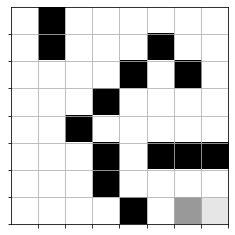

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

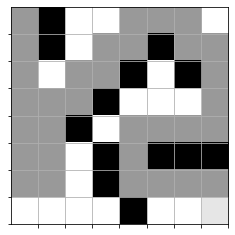

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.